# Synchrony Metric Comparison

This notebook is intended to compare the quality of spike synchrony metrics on simulated synchronized vs. desynchronized data.

In [1]:
PROJECT_PATH = 'G:/Shared drives/visual_encoding'

## Imports

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# elephant
from elephant.conversion import BinnedSpikeTrain
from elephant.spike_train_correlation import correlation_coefficient, covariance

# elephant reqs
import neo
import quantities as pq

# project-specific imports
import sys
sys.path.append('../..')
sys.path.append('../../sim_field')
from sim_field.funcs import sim_ou_process
from sim_field.timescale import comp_tau_acorr
from sim_field.utils import get_spike_times, convolve_psps
from allen_vc.analysis import compute_pyspike_metrics, compute_cv, compute_fano_factor

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

print("Imported!")

Imported!


## Settings

In [41]:
# simulation settings
N_SECONDS = 10
FS = 1000 # sampling frequency
N_NEURONS = 100
MEAN_RATE = 10 # average rate of each neuron (Hz)

# random process params
ALPHA = 1.
TAU_C = 25 / 1000

# metric settings
MAXLAG = 100

# metric calculation settings
N_ITERS = 100

## Simulation Functions

In [4]:
def sim_homogeneous_pool(rand_process=None, n_neurons=5, mu=20, variance=300, n_seconds=1, fs=1000,
                         tau_c=0.01):
    """
    *** modied to input white noise process or any random process ***
    
    simulate population spiking of N neurons firing at firing_rate each, return a
    spike trains roster of size (n_seconds*fs by n_neurons)

    Parameters
    ----------
    n_neurons : scalar, optional
        number of neurons in population. The default is 5.
    mu : scalar, optional
        mean of random walk. The default is 20.
    sigma : scalar, optional
        std of random walk. The default is 300.
    n_seconds : scalar, optional
        duration of signal (s). The default is 1.
    fs : scalar, optional
        sampling frequency (Hz). The default is 1000.
    tau : scalar, optional
        timescale (sec). The default is 0.01.

    Returns
    -------
    spikes : 2D array
        spike trains.
    rand_process : 1D array
        instantanious firing rate.

    """

    if rand_process is None:
        # simulate randon process (Ornstein-Uhlenbeck)
        rand_process, _ = sim_ou_process(n_seconds, fs, mu=mu, sigma=variance**0.5, tau=tau_c)
        # rand_process[rand_process < 0] = 0 # ensure all positive values

    # generate spikes from OU process
    spikes = np.zeros([n_neurons, len(rand_process)])

    # turn rates into spikes
    for j_bin in range(len(rand_process)):
        for i_neuron in range(n_neurons):
            if rand_process[j_bin] / fs > np.random.uniform():
                spikes[i_neuron, j_bin] = 1
    
    return spikes, rand_process

In [31]:
def run_homogeneouspool_sim(sync=True):
    # imports
    from scipy.signal import detrend

    # simulate spiking
    if sync:
        # simulate synchronized spiking
        spikes, rand_process = sim_homogeneous_pool(n_neurons=N_NEURONS, mu=MEAN_RATE, variance=MEAN_RATE**2, n_seconds=N_SECONDS, fs=FS, tau_c=TAU_C)
    
    else:
        # simulate desynchronized spiking
        rand_white = np.random.normal(loc=MEAN_RATE, scale=MEAN_RATE**0.5, size=N_SECONDS*FS)
        spikes, _ = sim_homogeneous_pool(rand_process=rand_white, n_neurons=N_NEURONS, n_seconds=N_SECONDS, fs=FS)

    # get spike times
    time = np.linspace(0,N_SECONDS,spikes.shape[1])
    spike_times = []
    for i_cell in range(len(spikes)):
        spike_times.append(get_spike_times(spikes[i_cell], time))

    # simulate LFP
    pop_spikes = np.sum(spikes, axis=0)
#     lfp, freq = convolve_psps(pop_spikes, FS)
#     lfp = detrend(lfp, type='constant')
    
    return spike_times, pop_spikes, spikes#, lfp

## Metric Analysis

In [69]:
def comp_spike_stats(spikes):
    
    # create lists to store individual spiketrain values
    fano_factors = []
    coefficients_of_variation = []
    
    # concatenate all spiketrains at the end to calculate SPIKE-distance
    spike_trains = []
    
    for train in spikes:
        
        # convert to neo object and compute metrics
        neo_obj = neo.SpikeTrain(train, units=pq.s, t_start=0, t_stop=N_SECONDS)
        fano_factors.append(compute_fano_factor(neo_obj, 1*pq.s))
        coefficients_of_variation.append(compute_cv(neo_obj))
        spike_trains.append(neo_obj)
        
    spk_dist, spk_sync = compute_pyspike_metrics(spike_trains)
    
    return spk_dist, spk_sync, np.mean(coefficients_of_variation), np.mean(fano_factors)
    

In [72]:
def calculate_sim_metrics(iters=1):
    
    metrics = []
    
    # calculate both sync and desync metrics for a number of iterations
    for i in tqdm(range(iters)):
        
        sync_spikes, sync_pop_spikes, _ = run_homogeneouspool_sim(sync=True)
        desync_spikes, desync_pop_spikes, _ = run_homogeneouspool_sim(sync=False)
        
        # compute tau based on lfp signal
        sync_tau = comp_tau_acorr(sync_pop_spikes, FS, MAXLAG)[0]
        desync_tau = comp_tau_acorr(desync_pop_spikes, FS, MAXLAG)[0]
        
        # append all metrics
        metrics.append([True, sync_tau] + list(comp_spike_stats(sync_spikes)))
        metrics.append([False, desync_tau] + list(comp_spike_stats(desync_spikes)))
        
    # create and return DataFrame
    df = pd.DataFrame(metrics, columns=['synchronized', 'tau', 'spike_distance', 'spike_synchrony', 'mean_coefficient_of_variation',
                                       'mean_fano_factor'])
    
    return df

In [48]:
# should spiking timescale be calculated per unit or over population

In [49]:
sync_spikes_neo, sync_pop_spikes, sync_spikes = run_homogeneouspool_sim(sync=True)
desync_spikes_neo, desync_pop_spikes, desync_spikes = run_homogeneouspool_sim(sync=False)

In [50]:
sync_pop_spikes

array([1., 0., 0., ..., 0., 0., 0.])

#### Autocorrelation Tau: MAXLAG Parameter

Text(0.5, 1.0, 'Population Spiking - Synchronous')

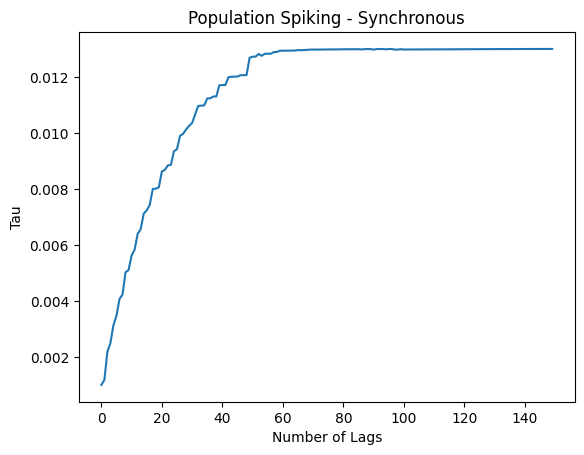

In [51]:
lags = np.arange(150)
taus = []
for lag in lags:
    tau = comp_tau_acorr(sync_pop_spikes, FS, lag)
    taus.append(tau)
    
plt.plot(lags, taus)
plt.ylabel("Tau")
plt.xlabel("Number of Lags")
plt.title("Population Spiking - Synchronous")

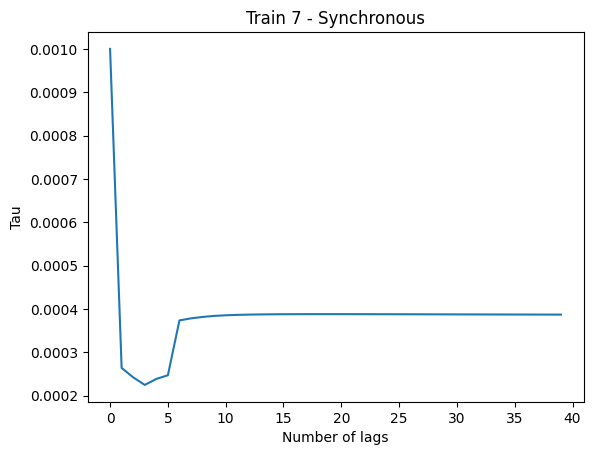

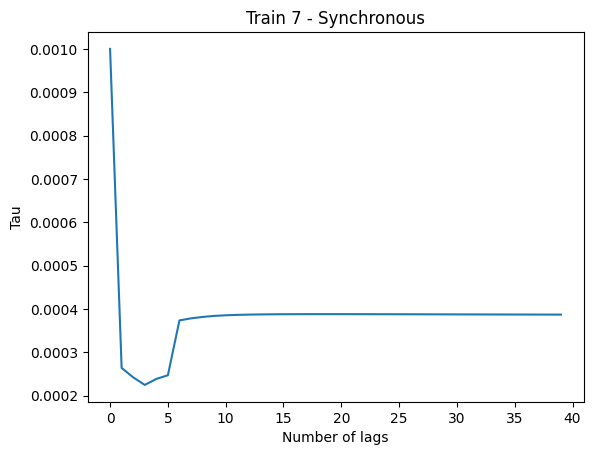

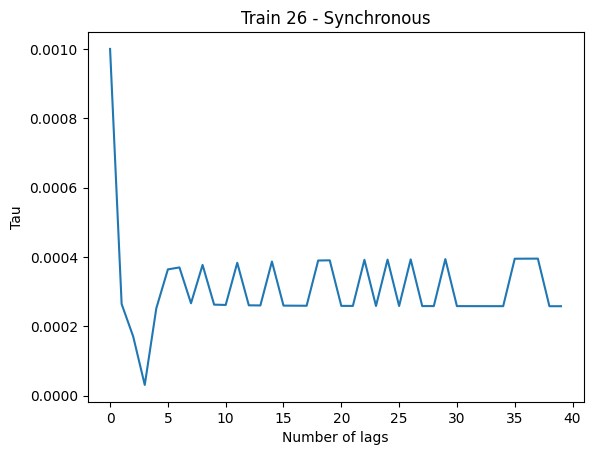

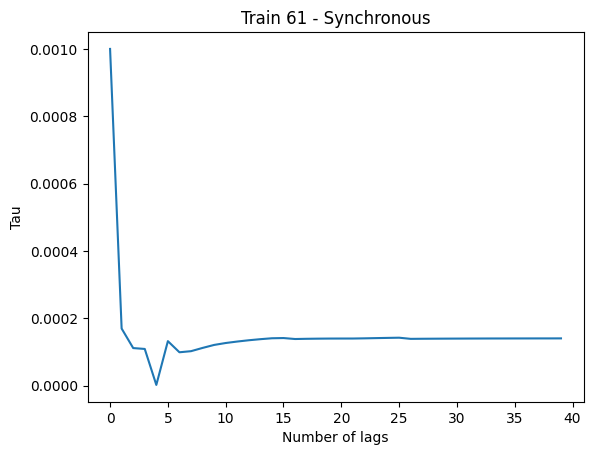

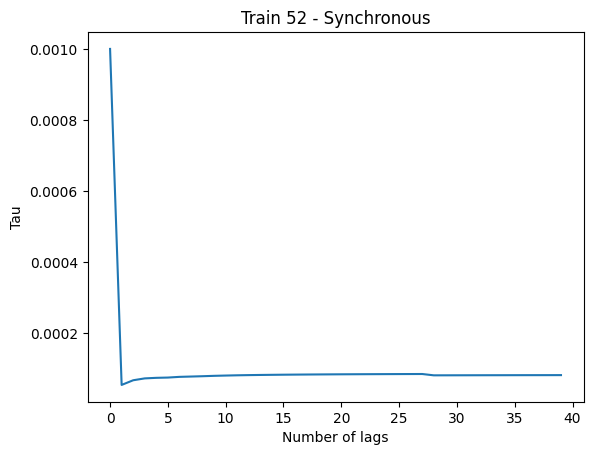

In [52]:
lags = np.arange(40)
for i in range(5):
    
    fig, ax = plt.subplots()
    
    j = np.random.randint(len(sync_spikes))
    
    taus = []
    for lag in lags:
        tau = comp_tau_acorr(sync_spikes[j], FS, lag) # causes invalid value/overflow warning
        taus.append(tau)
        
    plt.plot(lags, taus)
    plt.xlabel("Number of lags")
    plt.ylabel("Tau")
    plt.title(f"Train {j} - Synchronous")

Text(0.5, 1.0, 'Population Spiking - Asynchronous')

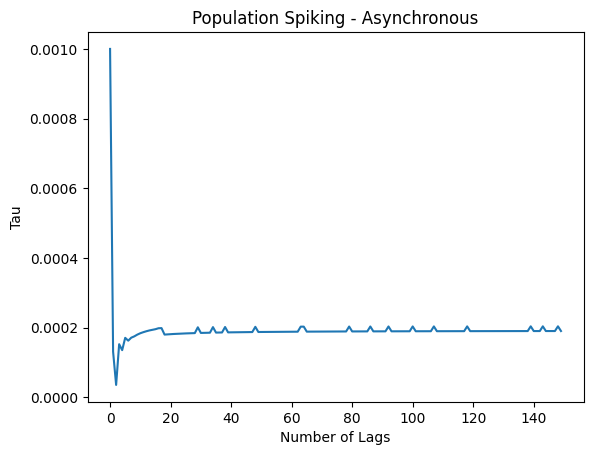

In [53]:
lags = np.arange(150)
taus = []
for lag in lags:
    tau = comp_tau_acorr(desync_pop_spikes, FS, lag)
    taus.append(tau)
    
plt.plot(lags, taus)
plt.ylabel("Tau")
plt.xlabel("Number of Lags")
plt.title("Population Spiking - Asynchronous")

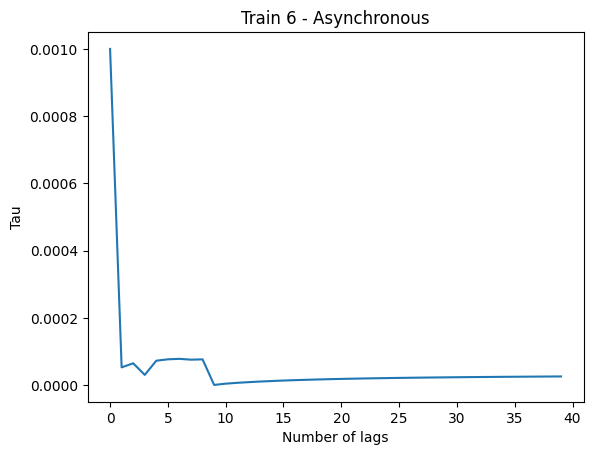

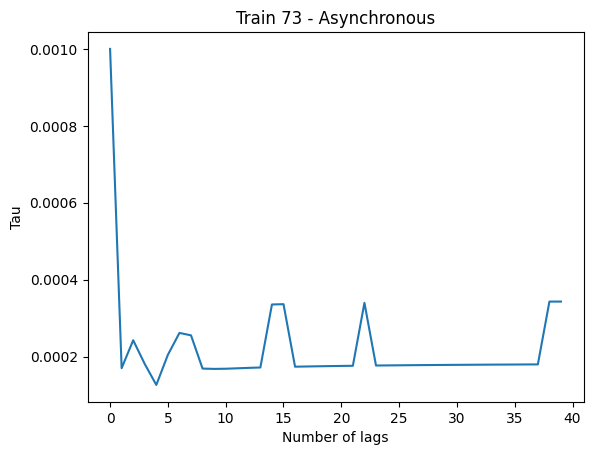

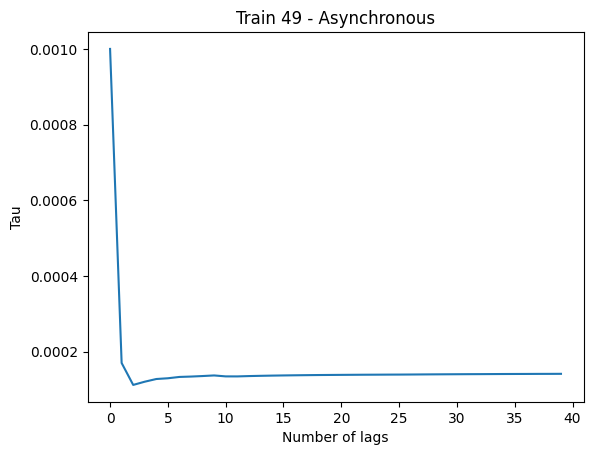

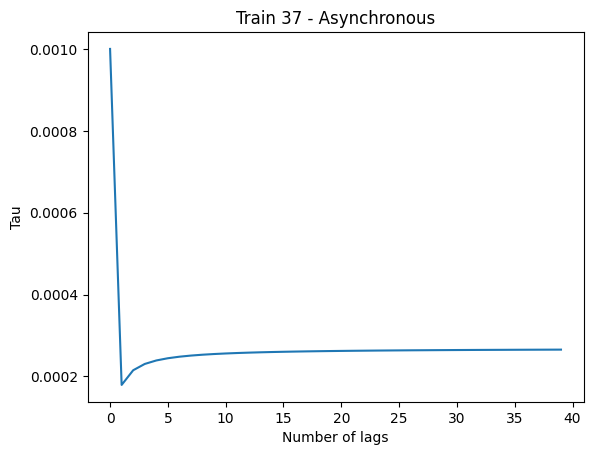

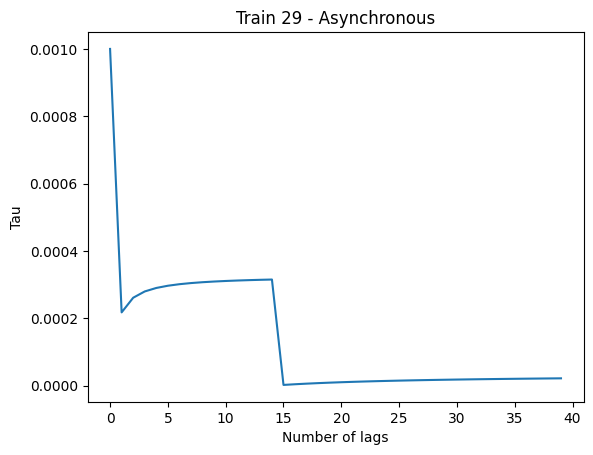

In [54]:
lags = np.arange(40)
for i in range(5):
    
    fig, ax = plt.subplots()
    
    j = np.random.randint(len(desync_spikes))
    
    taus = []
    for lag in lags:
        tau = comp_tau_acorr(desync_spikes[j], FS, lag) # causes invalid value/overflow warning
        taus.append(tau)
        
    plt.plot(lags, taus)
    plt.xlabel("Number of lags")
    plt.ylabel("Tau")
    plt.title(f"Train {j} - Asynchronous")

### Fano Factor: bin_size

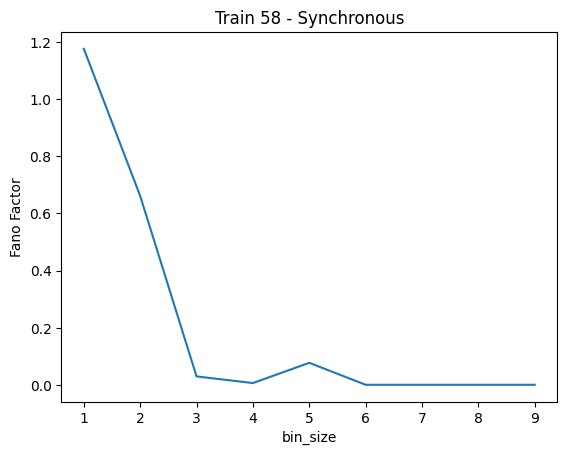

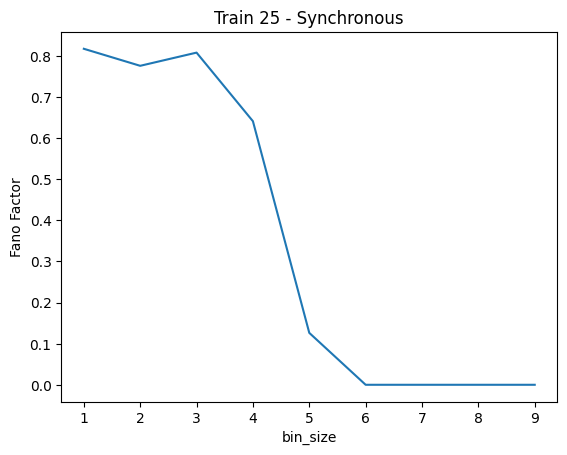

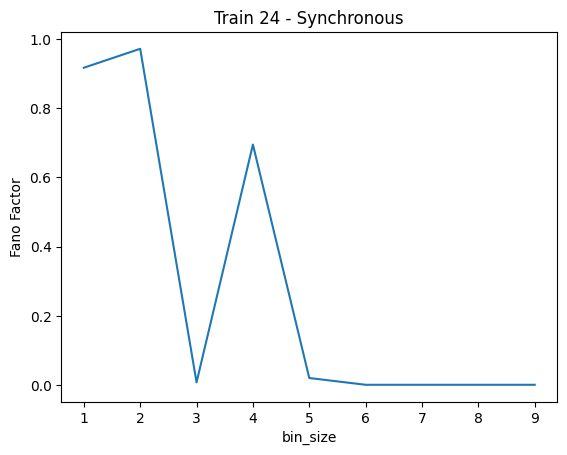

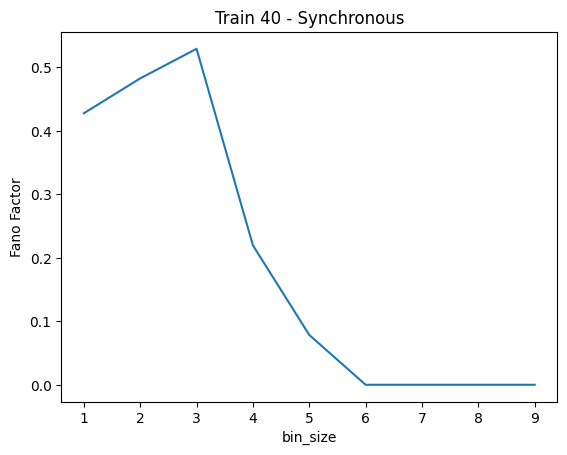

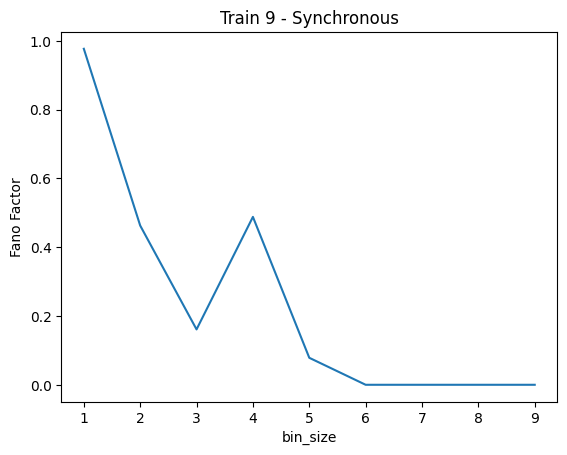

In [65]:
bin_sizes = np.arange(1, 10)
for i in range(5):
    
    fig, ax = plt.subplots()
    
    j = np.random.randint(len(sync_spikes_neo))
    
    ffs = []
    for bin_size in bin_sizes:
        ff = compute_fano_factor(neo.SpikeTrain(sync_spikes_neo[j], units=pq.s, t_start=0, t_stop=N_SECONDS), bin_size*pq.s)
        ffs.append(ff)
        
    plt.plot(bin_sizes, ffs)
    plt.xlabel("bin_size")
    plt.ylabel("Fano Factor")
    plt.title(f"Train {j} - Synchronous")

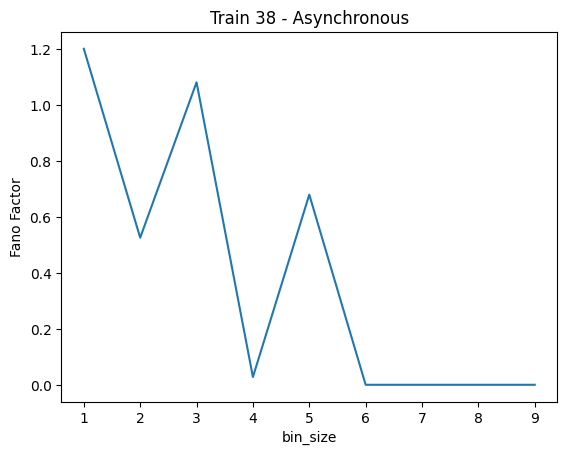

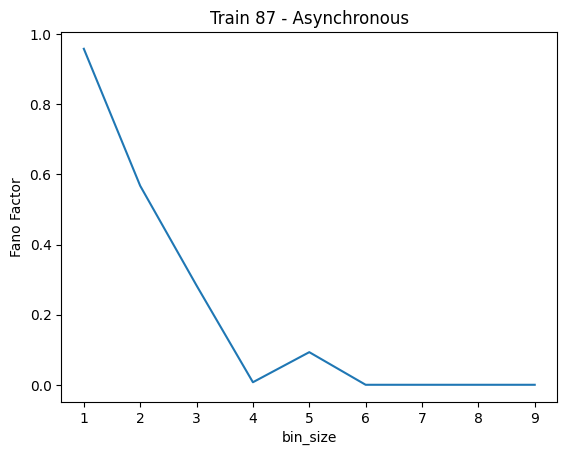

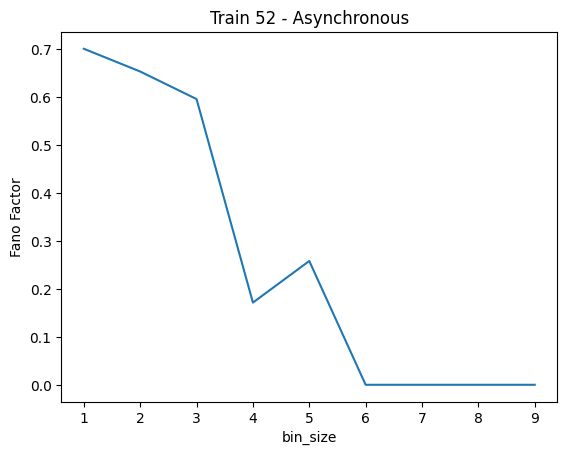

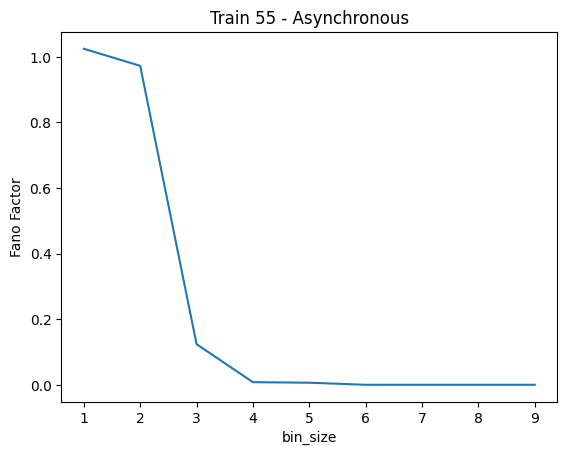

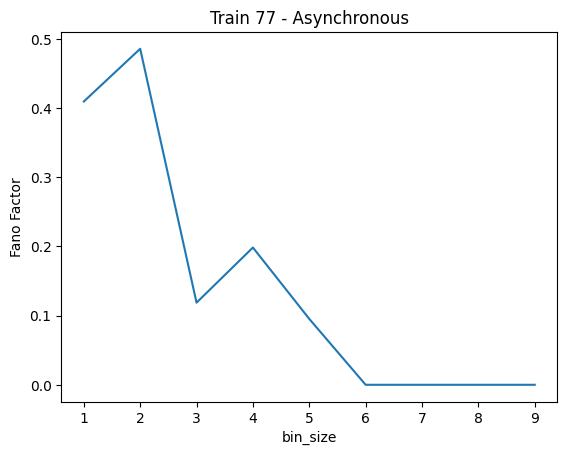

In [66]:
bin_sizes = np.arange(1, 10)
for i in range(5):
    
    fig, ax = plt.subplots()
    
    j = np.random.randint(len(desync_spikes_neo))
    
    ffs = []
    for bin_size in bin_sizes:
        ff = compute_fano_factor(neo.SpikeTrain(desync_spikes_neo[j], units=pq.s, t_start=0, t_stop=N_SECONDS), bin_size*pq.s)
        ffs.append(ff)
        
    plt.plot(bin_sizes, ffs)
    plt.xlabel("bin_size")
    plt.ylabel("Fano Factor")
    plt.title(f"Train {j} - Asynchronous")

## Run simulations

In [79]:
df = calculate_sim_metrics(iters=100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:17<00:00,  4.38s/it]


In [80]:
df

,synchronized,tau,spike_distance,spike_synchrony,mean_coefficient_of_variation,mean_fano_factor
0,True,0.011466,0.266139,0.262900,1.099565,1.076089
1,False,0.000266,0.293664,0.258121,0.964517,0.869445
2,True,0.009189,0.268413,0.258596,1.129036,1.222041
3,False,0.000152,0.296225,0.247035,0.998465,0.929069
4,True,0.010865,0.266728,0.263845,1.122511,1.197170
...,...,...,...,...,...,...
195,False,0.000255,0.295262,0.249856,0.983659,0.843516
196,True,0.009823,0.264200,0.259569,1.107045,1.011293
197,False,0.000141,0.296415,0.252191,0.997545,0.933500
198,True,0.011194,0.265272,0.257148,1.122192,1.222123


In [84]:
grouped.loc[False]

tau                              0.000193
spike_distance                   0.295223
spike_synchrony                  0.253000
mean_coefficient_of_variation    0.980144
mean_fano_factor                 0.888138
Name: False, dtype: float64

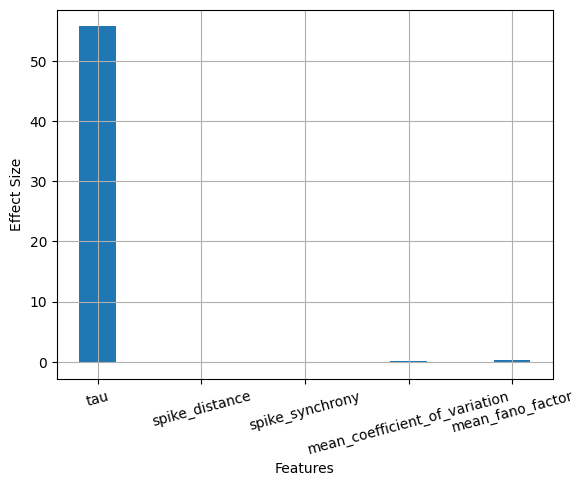

In [88]:
# Group the data by the "synchronized" column and calculate mean values
plot_df = df
grouped = plot_df.groupby("synchronized").mean()

# Define the columns to plot
columns_to_plot = ['tau', 'spike_distance', 'spike_synchrony', 'mean_coefficient_of_variation',
                                       'mean_fano_factor']

# Create the grouped barplot
fig, ax = plt.subplots()
width = 0.35
x = range(len(columns_to_plot))


group = (grouped.loc[True] - grouped.loc[False])/grouped.loc[False] # effect size compared to asychronous
ax.bar(
    [pos + width for pos in x],
    group[columns_to_plot],
    width
    # label=f"Synchronized: {label}"
)

ax.set_xlabel("Features")
ax.set_ylabel("Effect Size")
ax.set_xticks([pos + width for pos in x])
ax.set_xticklabels(columns_to_plot, rotation=15)
ax.grid(True)

plt.show()


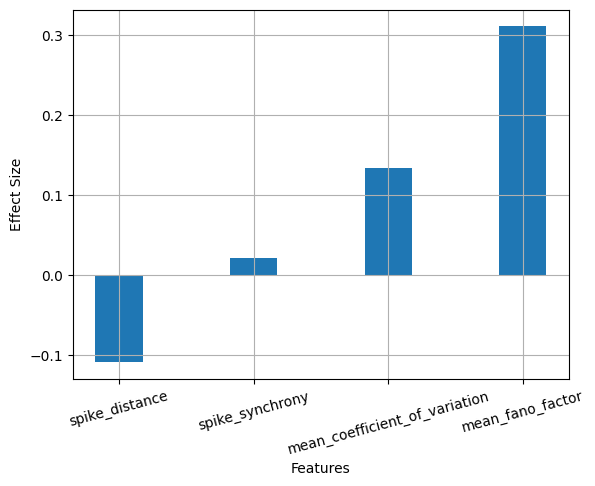

In [89]:
# Group the data by the "synchronized" column and calculate mean values
plot_df = df.drop(columns='tau')
grouped = plot_df.groupby("synchronized").mean()

# Define the columns to plot
columns_to_plot = ['spike_distance', 'spike_synchrony', 'mean_coefficient_of_variation',
                                       'mean_fano_factor']

# Create the grouped barplot
fig, ax = plt.subplots()
width = 0.35
x = range(len(columns_to_plot))


group = (grouped.loc[True] - grouped.loc[False])/grouped.loc[False] # effect size compared to asychronous
ax.bar(
    [pos + width for pos in x],
    group[columns_to_plot],
    width
    # label=f"Synchronized: {label}"
)

ax.set_xlabel("Features")
ax.set_ylabel("Effect Size")
ax.set_xticks([pos + width for pos in x])
ax.set_xticklabels(columns_to_plot, rotation=15)
ax.grid(True)

plt.show()


##### Effect Size Calculation: $\frac{\bar{M_{sync}} - \bar{M_{async}}}{\bar{M_{async}}}$

### PCA

In [90]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df.iloc[:, 1:])

PCA()

In [91]:
pd.DataFrame(pca.components_)

,0,1,2,3,4
0,0.025106,-0.072109,0.010785,0.325739,0.942310
1,-0.075421,0.236633,-0.029164,-0.908598,0.334537
2,0.153941,-0.790663,0.544915,-0.232659,0.009584
3,0.092237,-0.525520,-0.837864,-0.115153,0.006724
4,0.980549,0.193611,-0.009253,-0.030869,-0.000533


In [92]:
pca.explained_variance_ratio_

array([9.62716831e-01, 3.63472231e-02, 7.22893713e-04, 2.00834817e-04,
       1.22173935e-05])